In [94]:
import numpy as np
import pandas as pd
import scanpy as sc
import re
import anndata as ad

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

sc.settings.verbosity = 2  # reduce the verbosity
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.5 anndata==0.9.2 umap==0.5.3 numpy==1.21.5 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.0.2 statsmodels==0.13.2 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.10


# Functions

In [149]:
adata = sc.read_10x_mtx(
    'data/Mix1/G12C_1/sample_filtered_feature_bc_matrix/',
    var_names='gene_symbols',
    cache=True)

display(adata)

adata1 = sc.read_10x_mtx(
    'data/Mix1/G12C_1/sample_filtered_feature_bc_matrix/',
    var_names='gene_symbols',
    cache=True)

display(adata1)

adata2 = adata.concatenate(adata1)
adata2.obs.sort_index()

... reading from cache file cache/data-Mix1-G12C_1-sample_filtered_feature_bc_matrix-matrix.h5ad


AnnData object with n_obs × n_vars = 1747 × 32285
    var: 'gene_ids', 'feature_types'

... reading from cache file cache/data-Mix1-G12C_1-sample_filtered_feature_bc_matrix-matrix.h5ad


AnnData object with n_obs × n_vars = 1747 × 32285
    var: 'gene_ids', 'feature_types'

/Users/talbaron/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


,batch
AAACCCAAGGTGCCTC-1-0,0
AAACCCAAGGTGCCTC-1-1,1
AAACCCACATCCCGTT-1-0,0
AAACCCACATCCCGTT-1-1,1
AAACCCAGTAAGAACT-1-0,0
...,...
TTTGTTGCAGTCACGC-1-1,1
TTTGTTGTCCTTCACG-1-0,0
TTTGTTGTCCTTCACG-1-1,1
TTTGTTGTCGTAACCA-1-0,0


In [166]:
# Read and filter data (basic)
# Concatenate the two mixes (for G12C and G12D)
def read_data(condition, replicate_num = None, cache=True, unique=True, filter_mat=True, cells=3, genes=200):
    
    cond_to_path_dict = {'G12C': 'data/Mix/G12C/sample_filtered_feature_bc_matrix/',
                         'G12D': 'data/Mix/G12D/sample_filtered_feature_bc_matrix/',
                         'G12R': 'data/J951_G12R_mix_GEX/filtered_feature_bc_matrix'}
        
    if replicate_num is None:
        if condition == 'G12R':
            adata = sc.read_10x_mtx(
                cond_to_path_dict[condition],
                var_names='gene_symbols',
                cache=cache)
            
        else:
            adata = None
            path = cond_to_path_dict[condition]
            for mix in [1,2]:
                for replicate in [1,2,3]:
                    p = re.sub('Mix', f'Mix{mix}', path)
                    p = re.sub(condition, f'{condition}_{replicate}', p)
                    print(f'Reading from {p}')
                    a = sc.read_10x_mtx(
                        p,
                        var_names='gene_symbols',
                        cache=cache)
                    if adata:
                        adata = adata.concatenate(a)
                    else:
                        adata = a
    else:
        path1 = re.sub('Mix', 'Mix1', cond_to_path_dict[condition])
        path1 = re.sub(condition, f'{condition}_{replicate_num}', path1)
        
        path2 = re.sub('Mix', 'Mix2', cond_to_path_dict[condition])
        path2 = re.sub(condition, f'{condition}_{replicate_num}', path2)
        
        adata1 = sc.read_10x_mtx(
            path1,
            var_names='gene_symbols',
            cache=cache)
        
        adata2 = sc.read_10x_mtx(
            path2,
            var_names='gene_symbols',
            cache=cache)
        
        adata = adata1.concatenate(adata2)
    
    if unique:
        adata.var_names_make_unique()
    
    print(adata)
    
    sc.pl.highest_expr_genes(adata, n_top=20)

    if filter_mat:
        sc.pp.filter_cells(adata, min_genes=genes)
        sc.pp.filter_genes(adata, min_cells=cells)
        
        print(f'\nAfter filter:\n\n{adata}')
        
    return adata


# filter mt genes and plot
def mt_initial_preprocess_and_plot(adata, var='mt', pattern='mt-', violin=True, scatter=True):
    adata.var[var] = adata.var_names.str.startswith(pattern)  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=[var], percent_top=None, log1p=False, inplace=True)
    
    if violin:
        sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
    
    if scatter:    
        sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
        sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
        
    return adata


# filter, normalize, logarithmize and scale
def preprocess(adata, n_genes_by_counts=2e4, pct_counts_mt=5, normalize=True, target_sum=1e4, 
                         logarithmize=True, dynamic=True, min_mean=1, max_mean=6, min_disp=0.4):
    adata = adata[adata.obs.n_genes_by_counts < n_genes_by_counts, :]
    adata = adata[adata.obs.pct_counts_mt < pct_counts_mt, :]
    
    if normalize:
        sc.pp.normalize_total(adata, target_sum=target_sum)
        
    if logarithmize:
        sc.pp.log1p(adata)
    
    if dynamic:
        sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

    sc.pl.highly_variable_genes(adata)

    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]

    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

    sc.pp.scale(adata, max_value=10)

    return adata


# neighborhood graph
def neighborhood_graph_and_clustering(adata, n_neighbors=10, n_pcs=40, plot=False, color=['Sgk3'], use_raw=False, perplexity=10): # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)

    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    
    sc.tl.louvain(adata)
    sc.tl.leiden(adata)
    sc.tl.tsne(adata, perplexity=perplexity)
    sc.pl.tsne(adata, color=color, use_raw=use_raw)

    sc.tl.paga(adata)
    sc.pl.paga(adata, plot=plot)  
    sc.tl.umap(adata, init_pos='paga')    
    sc.pl.umap(adata, color=color, use_raw=use_raw)

    return adata


def markers(adata, clusters='leiden', method='wilcoxon', n_genes=25): # Other possibilities are 'logreg' and 't-test'
    sc.tl.rank_genes_groups(adata, clusters, method=method)
    sc.pl.rank_genes_groups(adata, n_genes=n_genes, sharey=False)
    
    top_genes_df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

    return adata, top_genes_df

Running G12C
-----------------------------------------------

Reading from data/Mix1/G12C_1/sample_filtered_feature_bc_matrix/
... reading from cache file cache/data-Mix1-G12C_1-sample_filtered_feature_bc_matrix-matrix.h5ad
Reading from data/Mix1/G12C_2/sample_filtered_feature_bc_matrix/
... reading from cache file cache/data-Mix1-G12C_2-sample_filtered_feature_bc_matrix-matrix.h5ad
Reading from data/Mix1/G12C_3/sample_filtered_feature_bc_matrix/
... reading from cache file cache/data-Mix1-G12C_3-sample_filtered_feature_bc_matrix-matrix.h5ad


/Users/talbaron/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


Reading from data/Mix2/G12C_1/sample_filtered_feature_bc_matrix/
... reading from cache file cache/data-Mix2-G12C_1-sample_filtered_feature_bc_matrix-matrix.h5ad


/Users/talbaron/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


Reading from data/Mix2/G12C_2/sample_filtered_feature_bc_matrix/
... reading from cache file cache/data-Mix2-G12C_2-sample_filtered_feature_bc_matrix-matrix.h5ad


/Users/talbaron/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


Reading from data/Mix2/G12C_3/sample_filtered_feature_bc_matrix/
... reading from cache file cache/data-Mix2-G12C_3-sample_filtered_feature_bc_matrix-matrix.h5ad


/Users/talbaron/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/Users/talbaron/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 9303 × 32285
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
normalizing counts per cell
    finished (0:00:00)


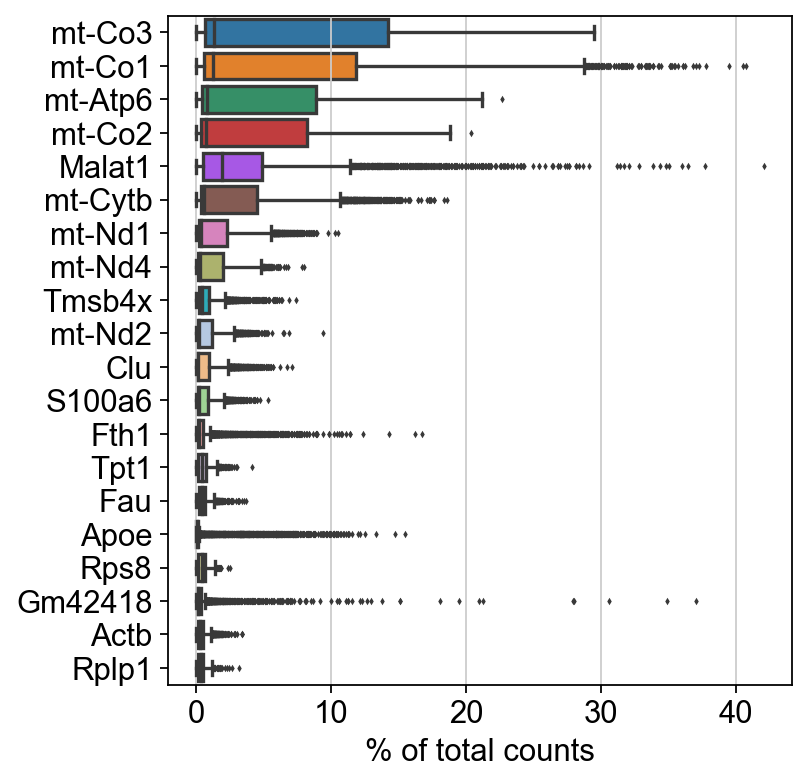

filtered out 1687 cells that have less than 200 genes expressed
filtered out 12580 genes that are detected in less than 3 cells

After filter:

AnnData object with n_obs × n_vars = 7616 × 19705
    obs: 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'


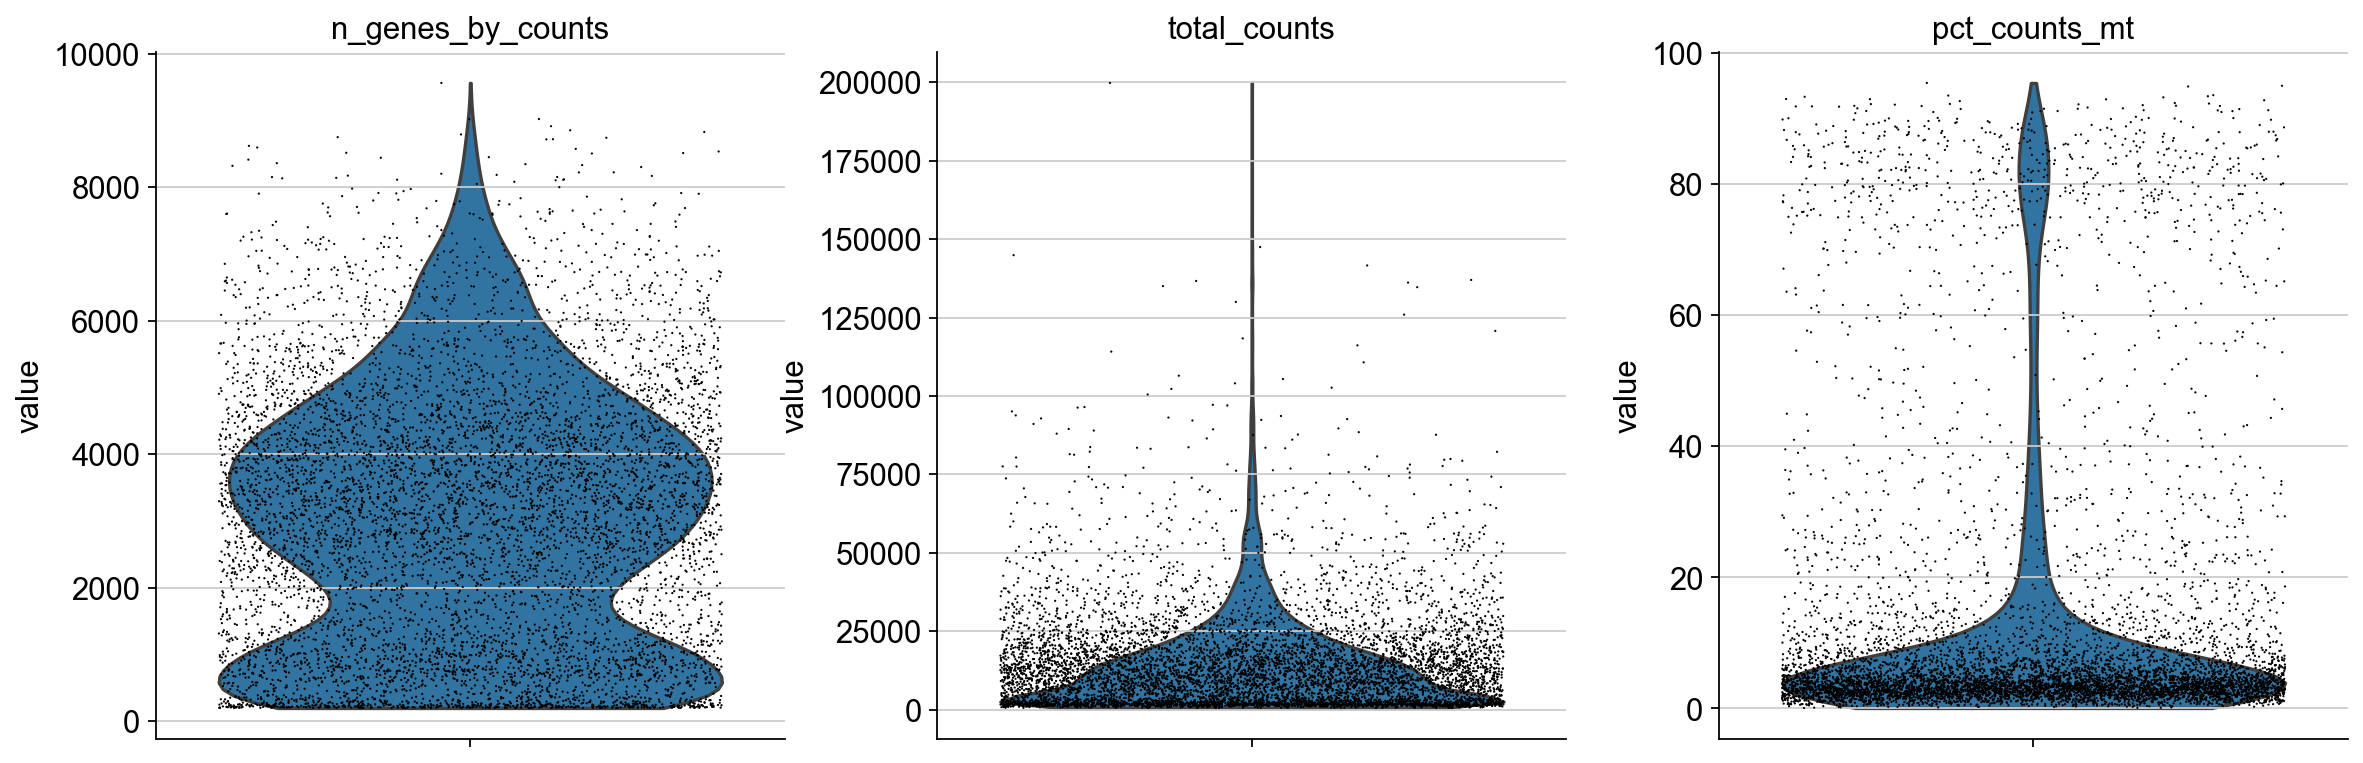

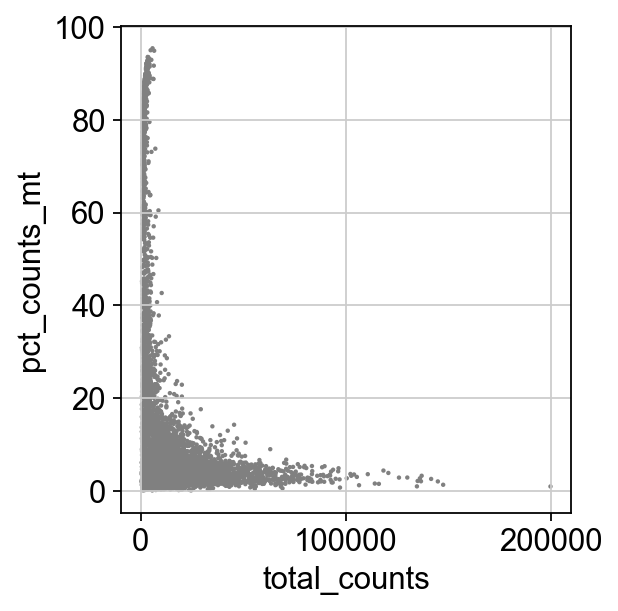

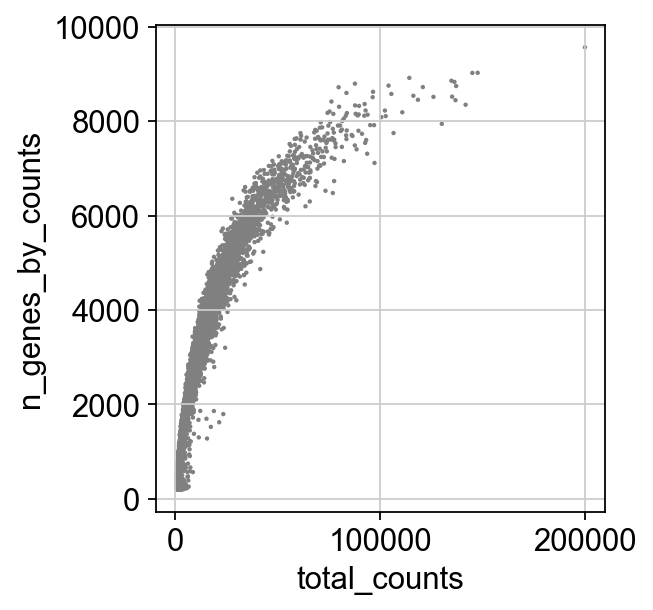

normalizing counts per cell


/Users/talbaron/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)


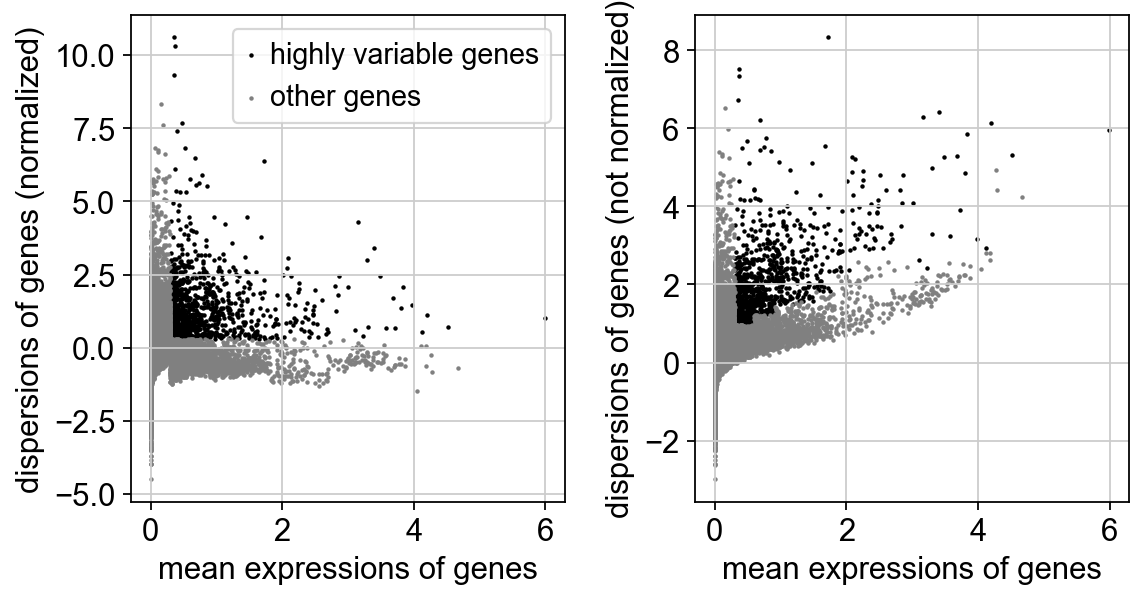

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


KeyboardInterrupt: 

In [173]:
results_map = {}
conditions = ['G12C', 'G12D', 'G12R']

for cond in conditions:
    print(f'Running {cond}\n----------------------------------------------------------------------------\n')
    adata = read_data(cond, replicate_num=None)
    adata = mt_initial_preprocess_and_plot(adata)
    adata = preprocess(adata, min_mean=0.3, min_disp=0.3)
    adata = neighborhood_graph_and_clustering(adata, color=['Cd4', 'Cd8a', 'Krt4', 'louvain', 'leiden'], 
                                              n_pcs=5, use_raw=True, perplexity=30)
    adata, top_genes_df = markers(adata)
    
    display(top_genes_df)
    
    results_map[cond] = {}
    results_map[cond]['adata'] = adata
    results_map[cond]['top_genes_df'] = top_genes_df
    
    break